## Worflow
- Set network parameters
- Optimize for twiddle bits
- Collect training and validation data
- Train for wiggly function
- Validate training

Fixed parameters:
- number of neurons

Swept parameters:
- function wiggliness
- fmax

In [1]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler
import nengo
from nengo_extras.plot_spikes import plot_spikes
import cvxpy as cvx
import pystorm
from pystorm.hal.net_builder import NetBuilder
from pystorm.hal.run_control import RunControl
from pystorm.hal.calibrator import Calibrator, PoolSpec
from pystorm.hal.data_utils import lpf, bin_to_spk_times, bins_to_rates

import utils

In [2]:
# swept parameters

# X = 16
# Y = 16

X = 32
Y = 32

REG_L2 = 0
# REG_L1 = [50, 10, 3,]
REG_L1 = [40, 10, 1]
# REG_L1 = [10]

FCN_F = 1
FMAX_OUT = 1000

BAD_IDX = np.array([133, 207, 217, 904])

# fixed parameters
# network parameters
NNEURON = X*Y
DIM = 1

DATA_DIR = "data/test_basis_pursuit/"
FIG_DIR = "figures/test_basis_pursuit/"

# experimental parameters
FMAX_IN = 2000
# TUNING_INPUT_POINTS = 240 # number of input points to take for collecting tuning data
# TUNING_POINT_TIME_NS = int(0.5*1E9) # time to record data per tuning curve input point
VALIDATION_SKIP = 7 # reserve every VALIDATION_SKIP points from tuning data for validation
TEST_INPUT_POINTS = 121 # number of input points to take for validating fit
TEST_POINT_TIME_NS = int(0.5*1E9) # time to collect data for each testing point
TESTING_DOWNSTREAM_NS = 10000 # downstream time resolution for testing
TESTING_UPSTREAM_NS = 100000 # upstream time resolution for testing
TESTING_RAW_SPIKES_DOWNSTREAM_NS = 1000 # downstream time resolution for collecting raw spikes for testing
TESTING_RAW_SPIKES_UPSTREAM_NS = 10000 # downstream time resolution for collecting raw spikes for testing
CLIP_TIME = 0.5 # how much of the initial data to discard during testing
TAU_READOUT = 0.1 # synaptic readout time constant
FSCALE = 1000.

In [3]:
PS_ORIG = PoolSpec(
    label = "pool",
    YX = (Y, X),
    loc_yx = (0, 0),
    D = DIM,
)

def FCN(x, f):
    """Base function used in testing"""
    return 0.5 + 0.5*np.sin(np.pi*f*x)

class ExpData:
    def __init__(self, fmax_in, fmax_out, fcn_f):
        self.fmax_in = fmax_in
        self.fmax_out = fmax_out
        self.fcn_f = fcn_f

In [4]:
def get_nrmse(fit, target, normal_factor):
    assert fit.shape == target.shape
    return np.sqrt(np.mean((fit - target)**2))/normal_factor

class CVXSolver(nengo.solvers.Solver):
    """Convex optimization solver

    Parameters
    ----------
    reg: float
        scales L2 cost
    reg_l1: float
        scales L1 cost
    """
    def __init__(self, reg=0.0001, reg_l1=0.0001):
        super(CVXSolver, self).__init__(weights=False)
        self.reg_l1 = reg_l1
        self.reg_l2 = reg

    def __call__(self, A, Y, rng=np.random, E=None):
        N = A.shape[1]   # number of neurons
        D = Y.shape[1]   # number of dimensions

        d = cvx.Variable((N, D))
        error = cvx.sum_squares(A * d - Y)
        l2_loss = self.reg_l2 * cvx.sum_squares(d)
        reg_l1 = cvx.Parameter(nonneg=True)
        reg_l1.value = self.reg_l1
        l1_loss = reg_l1 * cvx.norm(d, 1)

        cvx_prob = cvx.Problem(cvx.Minimize(error + l2_loss + l1_loss))
#         cvx_prob = cvx.Problem(cvx.Minimize(error + l2_loss + l1_loss), [-1 <= d, d <= 1])
        cvx_prob.solve()
        decoder = d.value
        rmses = np.sqrt(np.mean((Y-np.dot(A, decoder))**2, axis=0))

        return decoder, dict(rmses=rmses)

In [5]:
def load_tuning_data(exp_data, fnames, valid_skip):
    """Load tuning data from a set of files"""
    if isinstance(fnames, str):
        fnames = [fnames]
    datasets = []
    for fname in fnames:
        with open(fname, 'rb') as fhandle:
            datasets += [pickle.load(fhandle)]
    input_rates = np.array([dataset.input_rates for dataset in datasets]).flatten().reshape((-1, 1))
    spike_rates = np.vstack(np.array([dataset.spike_rates for dataset in datasets]))
    n_input_points = len(input_rates)
    start_idx = valid_skip//2
    t_idx = np.ones(n_input_points, dtype=bool)
    t_idx[start_idx::valid_skip] = False
    v_idx = ~t_idx
    
    sort_idx = np.argsort(input_rates, axis=0).flatten()
    input_rates = input_rates[sort_idx]
    spike_rates = spike_rates[sort_idx]
    
    spike_rates[:, BAD_IDX] = 0
    exp_data.training_input_rates = input_rates[t_idx]
    exp_data.training_spike_rates = spike_rates[t_idx]
    exp_data.validation_input_rates = input_rates[v_idx]
    exp_data.validation_spike_rates = spike_rates[v_idx]
    
def plot_tuning(exp_data, array_width, array_height):
    t_inputs = exp_data.training_input_rates
    t_spike_rates = exp_data.training_spike_rates
    v_inputs = exp_data.validation_input_rates
    v_spike_rates = exp_data.validation_spike_rates

    fig, (ax_t, ax_v) = plt.subplots(ncols=2, figsize=(14, 4), sharex=True)

    half_width = array_width//2
    t_lines = ax_t.plot(t_inputs, t_spike_rates)
    v_lines = ax_v.plot(v_inputs, v_spike_rates)
    for idx in range(array_height):
        start_l = idx*array_width
        start_r = start_l + half_width
        for idx in range(start_l, start_l+half_width):
            t_lines[idx].set_color('r')
            v_lines[idx].set_color('r')
        for idx in range(start_r, start_r+half_width):
            t_lines[idx].set_color('b')
            v_lines[idx].set_color('b')  
    ax_t.set_title("Training tuning data")
    ax_v.set_title("Validation tuning data")
    fig.savefig(FIG_DIR + "tuning" + "_" + str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) +
                "_fmax_in_" + str(exp_data.fmax_in) + ".png")

def plot_tuning_subset(exp_data, n_sample):
    t_inputs = exp_data.training_input_rates
    t_spike_rates = exp_data.training_spike_rates
    v_inputs = exp_data.validation_input_rates
    v_spike_rates = exp_data.validation_spike_rates

    idx = np.random.choice(np.arange(X*Y), n_sample, replace=False)
    fig, (ax_t, ax_v) = plt.subplots(ncols=2, figsize=(14, 4), sharex=True)

    t_lines = ax_t.plot(t_inputs, t_spike_rates[:, idx])
    v_lines = ax_v.plot(v_inputs, v_spike_rates[:, idx])
    ax_t.set_title("Training tuning data")
    ax_v.set_title("Validation tuning data")

In [6]:
EXP_DATA = ExpData(FMAX_IN, FMAX_OUT, FCN_F)
HAL = pystorm.hal.HAL()
NET_BUILDER = NetBuilder(HAL)
CALIBRATOR = Calibrator(HAL)

In [7]:
def build_net(ps_orig, net_builder, calibrator, exp_data):
    d_matrix = np.zeros((2, Y*X))    
    p_fname = (DATA_DIR + ps_orig.label + "_" + str(ps_orig.YX) + "_" + str(ps_orig.loc_yx) + ".pck")
    ps_opt, est_enc, est_off = utils.optimize_yield_w_cache(ps_orig, p_fname, calibrator)
    est_enc[np.isnan(est_enc)] = 0
    est_off[np.isnan(est_off)] = 0
    exp_data.ps = ps_opt
    intercepts, good_mask = calibrator.get_intercepts(est_enc, est_off)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title("sum good mask {}".format(np.sum(good_mask)))
    ax.hist(intercepts[~np.isnan(intercepts)], bins=50, range=(-2, 2))
    fig.savefig(FIG_DIR + "intercepts" + "_" + str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) + ".png")
    net = net_builder.create_single_pool_net_from_spec(exp_data.ps, d_matrix)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    xvals = np.linspace(-1, 1, 100)
    
    A_est = np.maximum(0, (est_enc @ xvals.reshape((1, -100))).T + est_off)
    ax.plot(xvals, A_est)
    return net, ps_opt, est_enc, est_off

checking cache for data/test_basis_pursuit/pool_(32, 32)_(0, 0).pck
found cache


/Users/samfok/Code/pystorm/pystorm/hal/calibrator.py:793: RuntimeWarning: invalid value encountered in true_divide
  intercepts = -offsets / gains
/Users/samfok/Code/pystorm/pystorm/hal/calibrator.py:794: RuntimeWarning: invalid value encountered in less
  good_mask = (intercepts < 1) & (intercepts > -1)
/Users/samfok/Code/pystorm/pystorm/hal/calibrator.py:794: RuntimeWarning: invalid value encountered in greater
  good_mask = (intercepts < 1) & (intercepts > -1)


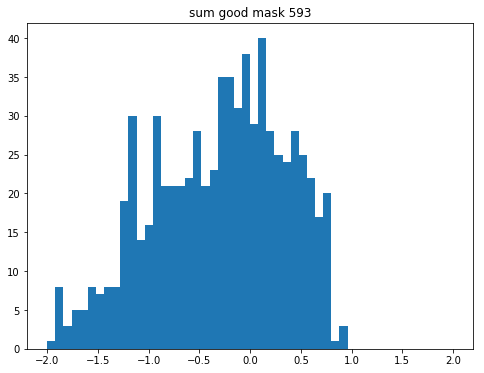

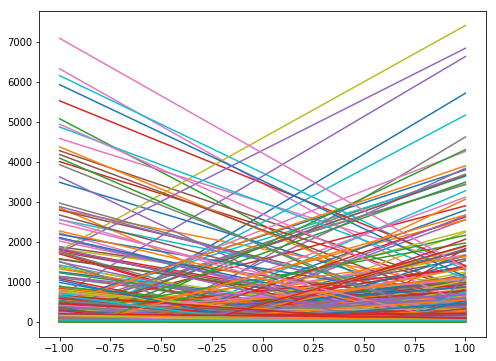

In [8]:
NET, PS_OPT, ENC_OPT, OFF_OPT = build_net(PS_ORIG, NET_BUILDER, CALIBRATOR, EXP_DATA)
# RUN_CONTROL = RunControl(HAL, NET)
# HAL.map(NET)

# Collect Tuning Data

- Check that tuning curves look reasonable

In [9]:
class TuningData:
    def __init__(self, input_rates, spike_rates):
        self.input_rates = input_rates
        self.spike_rates = spike_rates
DATA_TUNING_DIR = "data/test_basis_pursuit/tuning/"
DATA_FNAME_BASE = (DATA_TUNING_DIR + str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) +
                   "_fmax_in_" + str(FMAX_IN) + "_samples_120_sample_time_500ms_discard_0.4")
DATA_FNAMES = [
    DATA_FNAME_BASE + "_set_0.pck",
]
load_tuning_data(EXP_DATA, DATA_FNAMES, VALIDATION_SKIP)

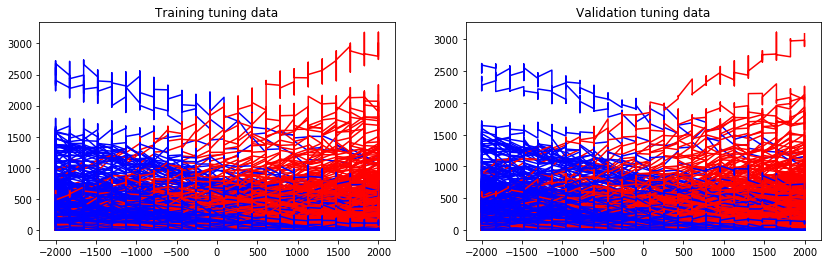

In [10]:
plot_tuning(EXP_DATA, X, Y)

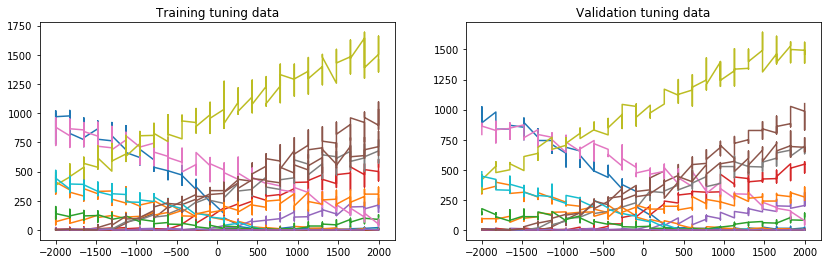

In [11]:
plot_tuning_subset(EXP_DATA, 16) # look at a smaller subset of the data

# Train, Validate, Test Decoders

Solving for fmax_out 1000 fcn_f 1.0
checking cache for data/test_basis_pursuit/decoders_select_(32, 32)_(0, 0)_fmax_out_1000_L1_40_L2_0.pck
found cache
checking cache for data/test_basis_pursuit/decoders_(32, 32)_(0, 0)_fmax_out_1000_L1_40_L2_0.pck
found cache
[130 256 902]
	reg 4.0e+01 v_nrmse 0.203784 nz_d    3
Solving for fmax_out 1000 fcn_f 1.0
checking cache for data/test_basis_pursuit/decoders_select_(32, 32)_(0, 0)_fmax_out_1000_L1_10_L2_0.pck
found cache
checking cache for data/test_basis_pursuit/decoders_(32, 32)_(0, 0)_fmax_out_1000_L1_10_L2_0.pck
found cache
[113 130 276 343 451 513 650 774]
	reg 1.0e+01 v_nrmse 0.089127 nz_d    8
Solving for fmax_out 1000 fcn_f 1.0
checking cache for data/test_basis_pursuit/decoders_select_(32, 32)_(0, 0)_fmax_out_1000_L1_1_L2_0.pck
found cache
checking cache for data/test_basis_pursuit/decoders_(32, 32)_(0, 0)_fmax_out_1000_L1_1_L2_0.pck
found cache
[ 22  43  69 100 113 119 125 128 130 134 146 209 215 276 323 343 451 462
 489 513 524 530 5

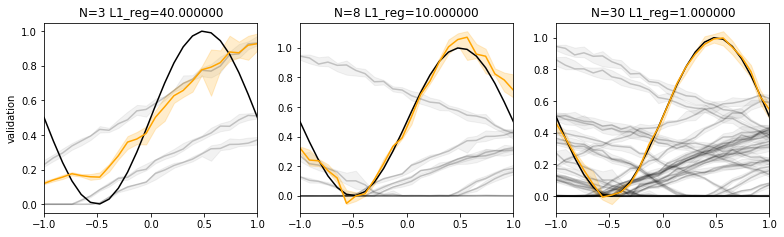

In [17]:
def fit_decoders(rates, target_function, reg_l1, reg_l2):
    solver = CVXSolver(reg=reg_l2, reg_l1=reg_l1)
    decoders, info = solver(rates/FSCALE, target_function/FSCALE)
    decoders = decoders.clip(-1, 1)
    return decoders, info

def get_percentiles(inputs, outputs):
    u_inp = np.unique(inputs.flatten())
    output_50 = np.zeros((len(u_inp), outputs.shape[1]))
    output_10 = np.zeros((len(u_inp), outputs.shape[1]))
    output_90 = np.zeros((len(u_inp), outputs.shape[1]))
    for inp_idx, inp_val in enumerate(u_inp):
        idx = inputs.flatten() == inp_val
        output_10[inp_idx] = np.percentile(outputs[idx], 10, axis=0)
        output_50[inp_idx] = np.median(outputs[idx], axis=0)
        output_90[inp_idx] = np.percentile(outputs[idx], 90, axis=0)
    return u_inp, output_10, output_50, output_90

def run_fits(exp_data):
    exp_data.decoders = []
    exp_data.training_targets = []
    exp_data.reg = np.zeros(len(REG_L1))
    
    v_input = exp_data.validation_input_rates/exp_data.fmax_in
    v_spike_rates = exp_data.validation_spike_rates

    t_input = exp_data.training_input_rates/exp_data.fmax_in
    t_spike_rates = exp_data.training_spike_rates

#     t_spike_rates *= 2*FMAX_OUT/max_rate
#     v_spike_rates *= 2*FMAX_OUT/max_rate
#     t_spike_rates = np.maximum(0, (ENC_OPT @ t_input.reshape((1, -1))).T + OFF_OPT)
#     v_spike_rates = np.maximum(0, (ENC_OPT @ v_input.reshape((1, -1))).T + OFF_OPT)

    nrows = 1
    ncols = len(REG_L1)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4+1, nrows*2.5+1))
    axs = [axs]
    for idx, reg_l1 in enumerate(REG_L1):
        print("Solving for fmax_out {:.0f} fcn_f {:.1f}".format(FMAX_OUT, FCN_F))
        t_target = FMAX_OUT * FCN(t_input, FCN_F) 
        v_nrmse = np.zeros(len(REG_L1))
        v_target = FMAX_OUT * FCN(v_input, FCN_F)

        fname_select_cache = (
            DATA_DIR + "decoders_select_" +
            str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) +
            "_fmax_out_" + str(FMAX_OUT) +
            "_L1_" + str(reg_l1) + "_L2_" + str(0) + ".pck")
        fname_basis_cache = (
            DATA_DIR + "decoders_" +
            str(PS_ORIG.YX) + "_" + str(PS_ORIG.loc_yx) +
            "_fmax_out_" + str(FMAX_OUT) +
            "_L1_" + str(reg_l1) + "_L2_" + str(REG_L2) + ".pck")
        
        threshold = 1E-6 # what to consider a nonzero weight
        def cached_select_decoders():
            decoders, info = fit_decoders(
                t_spike_rates, t_target, reg_l1, 0)
            return decoders, info
        decoders_select, info = utils.cache_fun(fname_select_cache, cached_select_decoders)
        nzd_idx = np.abs(decoders_select.flatten()) > threshold
        
        t_basis_spike_rates = t_spike_rates[:, nzd_idx]
        v_basis_spike_rates = v_spike_rates[:, nzd_idx]
        
        t_max_rate = np.max(t_basis_spike_rates)
        v_max_rate = np.max(v_basis_spike_rates)
        max_rate = max(t_max_rate, v_max_rate)
        
        def cached_fit_decoders():
            decoders, info = fit_decoders(
                t_basis_spike_rates, t_target, 0, 0)
            return decoders, info
        decoders, info = utils.cache_fun(fname_basis_cache, cached_fit_decoders)
        t_fit = np.dot(t_basis_spike_rates, decoders)
        v_fit = np.dot(v_basis_spike_rates, decoders)
        v_nrmse[idx] = get_nrmse(v_fit, v_target, FMAX_OUT)
        
        u_t_input, t_fit_10, t_fit_50, t_fit_90 = get_percentiles(t_input, t_fit)
        u_v_input, v_fit_10, v_fit_50, v_fit_90 = get_percentiles(v_input, v_fit)
        
        _, t_basis_spike_rates_10, t_basis_spike_rates_50, t_basis_spike_rates_90 = get_percentiles(t_input, t_basis_spike_rates)
        _, v_basis_spike_rates_10, v_basis_spike_rates_50, v_basis_spike_rates_90 = get_percentiles(v_input, v_basis_spike_rates)
#         axs[0][idx].plot(t_input, t_target*max_rate/FMAX_OUT, 'k')
#         axs[1][idx].plot(v_input, v_target*max_rate/FMAX_OUT, 'k')
        
        t_target /= FMAX_OUT
        v_target /= FMAX_OUT
        t_fit_10 /= FMAX_OUT 
        t_fit_50 /= FMAX_OUT 
        t_fit_90 /= FMAX_OUT 
        v_fit_10 /= FMAX_OUT 
        v_fit_50 /= FMAX_OUT 
        v_fit_90 /= FMAX_OUT 
        t_basis_spike_rates_10 /= max_rate
        t_basis_spike_rates_50 /= max_rate
        t_basis_spike_rates_90 /= max_rate
        v_basis_spike_rates_10 /= max_rate
        v_basis_spike_rates_50 /= max_rate
        v_basis_spike_rates_90 /= max_rate
        
        axs[0][idx].plot(v_input, v_target, 'k')
        
        nnzd = np.sum(nzd_idx)
        
#         axs[0][idx].plot(t_input, t_fit*max_rate/FMAX_OUT, 'orange')
#         axs[1][idx].plot(v_input, v_fit*max_rate/FMAX_OUT, 'orange')
        def plot_percentiles(ax, inputs, outputs_10, outputs_50, outputs_90, fill_kwargs, plot_kwargs):
            N = outputs_10.shape[1]
            for n in range(N):
                ax.fill_between(inputs, outputs_10[:, n], outputs_90[:, n], **fill_kwargs)
                ax.plot(inputs, outputs_50[:, n], **plot_kwargs)
    
        print(np.nonzero(nzd_idx)[0])
#         if idx == 2:
#             plt_idx = np.arange(0, 32)
# #             plt_idx = np.arange(31, 32)
#             print(np.nonzero(nzd_idx)[0][plt_idx])
#             plot_percentiles(axs[0][idx], u_t_input, t_basis_spike_rates_10[:, plt_idx], t_basis_spike_rates_50[:, plt_idx], t_basis_spike_rates_90[:, plt_idx], {"color":"k", "alpha":0.05}, {"color":"k", "alpha":0.2})
#             plot_percentiles(axs[1][idx], u_v_input, v_basis_spike_rates_10[:, plt_idx], v_basis_spike_rates_50[:, plt_idx], v_basis_spike_rates_90[:, plt_idx], {"color":"k", "alpha":0.05}, {"color":"k", "alpha":0.2})
#         else:
#             plot_percentiles(axs[0][idx], u_t_input, t_basis_spike_rates_10, t_basis_spike_rates_50, t_basis_spike_rates_90, {"color":"k", "alpha":0.05}, {"color":"k", "alpha":0.2})
#             plot_percentiles(axs[1][idx], u_v_input, v_basis_spike_rates_10, v_basis_spike_rates_50, v_basis_spike_rates_90, {"color":"k", "alpha":0.05}, {"color":"k", "alpha":0.2})
            
            
        plot_percentiles(axs[0][idx], u_v_input, v_basis_spike_rates_10, v_basis_spike_rates_50, v_basis_spike_rates_90, {"color":"k", "alpha":0.05}, {"color":"k", "alpha":0.2})
        plot_percentiles(axs[0][idx], u_v_input, v_fit_10, v_fit_50, v_fit_90, {"color":"orange", "alpha":0.2}, {"color":"orange"})    
        
        print("\treg {:.1e} v_nrmse {:.6f} nz_d {: 4d}".format(reg_l1, v_nrmse[idx], np.sum(nzd_idx)))
        exp_data.decoders += [decoders]
        exp_data.reg[idx] = REG_L1[idx]
        axs[0][idx].set_title("N={:d} L1_reg={:f}".format(nnzd, reg_l1))
        axs[0][idx].set_xlim([-1, 1])
    axs[0][0].set_ylabel("validation")
    exp_data.training_input = t_input

run_fits(EXP_DATA)